# Recurrent Neural Network Example

Build a recurrent neural network (LSTM) with TensorFlow 2.0.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## RNN Overview

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" alt="nn" style="width: 600px;"/>

References:
- [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf), Sepp Hochreiter & Jurgen Schmidhuber, Neural Computation 9(8): 1735-1780, 1997.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then handle 28 sequences of 28 timesteps for every sample.

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow v2.
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).
num_features = 784 # data features (img shape: 28*28).

# Training Parameters
learning_rate = 0.001
training_steps = 1000
batch_size = 32
display_step = 100

# Network Parameters
# MNIST image shape is 28*28px, we will then handle 28 sequences of 28 timesteps for every sample.
num_input = 28 # number of sequences.
timesteps = 28 # timesteps.
num_units = 32 # number of neurons for the LSTM layer.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, 28, 28]), x_test.reshape([-1, 28, 28])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Create LSTM Model.
class LSTM(Model):
    # Set layers.
    def __init__(self):
        super(LSTM, self).__init__()
        # RNN (LSTM) hidden layer.
        self.lstm_layer = layers.LSTM(units=num_units)
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        # LSTM layer.
        x = self.lstm_layer(x)
        # Output layer (num_classes).
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build LSTM model.
lstm_net = LSTM()

In [6]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Adam optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [7]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = lstm_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = lstm_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update weights following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = lstm_net(batch_x, is_training=True)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 1.754877, accuracy: 0.375000
step: 200, loss: 1.059971, accuracy: 0.656250
step: 300, loss: 0.852215, accuracy: 0.656250
step: 400, loss: 0.841060, accuracy: 0.750000
step: 500, loss: 0.797701, accuracy: 0.781250
step: 600, loss: 0.502728, accuracy: 0.843750
step: 700, loss: 0.585135, accuracy: 0.812500
step: 800, loss: 0.472429, accuracy: 0.843750
step: 900, loss: 0.219134, accuracy: 0.968750
step: 1000, loss: 0.158509, accuracy: 0.968750


Test Accuracy: 0.895900


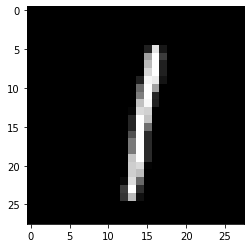

Model prediction: 1


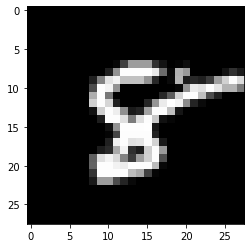

Model prediction: 8


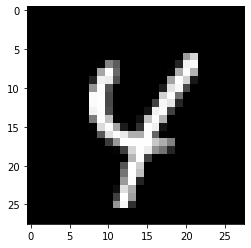

Model prediction: 4


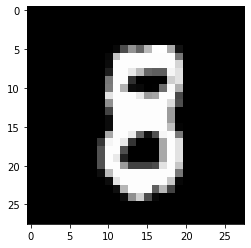

Model prediction: 8


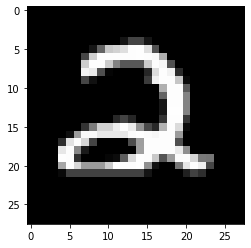

Model prediction: 2


In [9]:
# Test model on validation set.
pred = lstm_net(x_test, is_training = False)
print("Test Accuracy: %f" % accuracy(pred, y_test))

import random
import matplotlib.pyplot as plt

# Predict 5 images from validation set.
n_images = 5
test_images = np.array(random.choices(x_test, k = n_images))
predictions = lstm_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))